In [ ]:
import torch

from library import banknote_dataset
from library import train_flow

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
DEVICE = 'cpu'
DATA_DIM = 4

In [ ]:
col_names = ['Variance_WT', 'Skewness_WT', 'Curtosis_WT', 'Entropy', 'Class']
pandas_data = pd.read_csv("https://raw.githubusercontent.com/tdishant/Banknote-Authentication/master/data_banknote_authentication_dataset.csv", skiprows=1, header=None, names=col_names)
pandas_data.head(10)

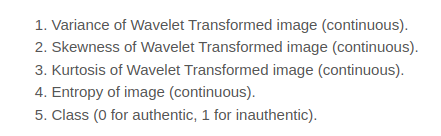

In [ ]:
from typing_extensions import dataclass_transform
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = pandas_data.iloc[:,:-1].values
y = pandas_data.iloc[:,-1:].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

#Training and Testing Set for classifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#Training and Testing Set for normalizing flow
X_train_authentic = [X_train[i] for i in range(len(X_train)) if y_train[i]==0]
X_train_inauthentic = [X_train[i] for i in range(len(X_train)) if y_train[i]==1]
X_test_authentic = [X_test[i] for i in range(len(X_test)) if y_test[i]==0]
X_test_inauthentic = [X_test[i] for i in range(len(X_test)) if y_test[i]==1]

banknote_dataset.plotting_data(data_authentic=X_train_authentic, data_inauthentic=X_train_inauthentic)

In [ ]:
from torch.distributions.normal import Normal

# Create the standard normal distribution
y_distribution = Normal(torch.zeros(DATA_DIM, device=DEVICE), torch.ones(DATA_DIM, device=DEVICE))

distribution_sample = [y_distribution.sample().unsqueeze(0).data.cpu().numpy() for x in range(505)]

if (0):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
  fig.suptitle("Example Labels in the Standard Normal Disribution", fontsize=16)
  ax1.scatter([item[0,0] for item in distribution_sample], [item[0,1] for item in distribution_sample])
  ax2.scatter([item[0,2] for item in distribution_sample], [item[0,3] for item in distribution_sample])
  plt.show()

In [ ]:
import torch.nn as nn

from torch.utils.data import DataLoader
from tqdm import tqdm

authentic_flow = train_flow.training(X_train_authentic, device=DEVICE, data_dim=DATA_DIM, y_distribution=y_distribution)
inauthentic_flow = train_flow.training(X_train_inauthentic, device=DEVICE, data_dim=DATA_DIM, y_distribution=y_distribution)

In [ ]:
banknote_dataset.plotting_data(data_authentic=X_test_authentic, data_inauthentic=X_test_inauthentic)

In [ ]:
res_auth, jac_auth = authentic_flow.forward(torch.tensor(np.float32(X_test_authentic), device=DEVICE))
res_auth = res_auth.data.cpu().numpy()

res_inauth, jac_inauth = inauthentic_flow.forward(torch.tensor(np.float32(X_test_inauthentic), device=DEVICE))
res_inauth = res_inauth.data.cpu().numpy()

banknote_dataset.plotting_data(data_authentic=res_auth, data_inauthentic=res_inauth)

In [ ]:
from scipy.stats import norm

full_prob_list_authentic = []
for result in res_auth:
  prob_list = []
  for prop in result:
    prob_list.append(norm.pdf(prop))
  full_prob_list_authentic.append(prob_list)

full_prob_list_inauthentic = []
for result in res_inauth:
  prob_list = []
  for prop in result:
    prob_list.append(norm.pdf(prop))
  full_prob_list_inauthentic.append(prob_list)

banknote_dataset.plotting_data(data_authentic=full_prob_list_authentic, data_inauthentic=full_prob_list_inauthentic)

In [ ]:
inverted_authentic = authentic_flow.invert(torch.tensor(np.float32(full_prob_list_authentic), device=DEVICE))
inverted_authentic = inverted_authentic.data.cpu().numpy()
inverted_inauthentic = inauthentic_flow.invert(torch.tensor(np.float32(full_prob_list_inauthentic), device=DEVICE))
inverted_inauthentic = inverted_inauthentic.data.cpu().numpy()

banknote_dataset.plotting_data(data_authentic=inverted_authentic, data_inauthentic=inverted_inauthentic)

In [ ]:
PERCENT_CUT_AUTHENTIC = 0.9
PERCENT_CUT_INAUTHENTIC = 0.9

inverted_sum_authentic = [np.min(a) for a in inverted_authentic]
prob_sum_pairs_authentic = [(inverted_sum_authentic[i], X_test_authentic[i]) for i in range(len(inverted_sum_authentic))]
inverted_sum_inauthentic = [np.min(a) for a in inverted_inauthentic]
prob_sum_pairs_inauthentic = [(inverted_sum_inauthentic[i], X_test_inauthentic[i]) for i in range(len(inverted_sum_inauthentic))]

prob_sum_pairs_authentic.sort(key=lambda x: x[0])
cut = int(PERCENT_CUT_AUTHENTIC * len(inverted_sum_authentic))
prob_sum_pairs_authentic_cut = prob_sum_pairs_authentic[:cut]
prob_sum_pairs_authentic_rest = prob_sum_pairs_authentic[cut:]
prob_sum_pairs_inauthentic.sort(key=lambda x: x[0])
cut = int(PERCENT_CUT_INAUTHENTIC * len(inverted_sum_inauthentic))
prob_sum_pairs_inauthentic_cut = prob_sum_pairs_inauthentic[:cut]
prob_sum_pairs_inauthentic_rest = prob_sum_pairs_inauthentic[cut:]

cut_list_authentic = [a[1] for a in prob_sum_pairs_authentic_cut]
rest_list_authentic = [a[1] for a in prob_sum_pairs_authentic_rest]
cut_list_inauthentic = [a[1] for a in prob_sum_pairs_inauthentic_cut]
rest_list_inauthentic = [a[1] for a in prob_sum_pairs_inauthentic_rest]
banknote_dataset.plotting_data(data_authentic=cut_list_authentic, data_inauthentic=cut_list_inauthentic)

In [ ]:
banknote_dataset.plotting_data(data_authentic=X_test_authentic, data_inauthentic=X_test_inauthentic)
banknote_dataset.plotting_data(data_authentic=cut_list_authentic, data_inauthentic=cut_list_inauthentic)
banknote_dataset.plotting_data(data_authentic=rest_list_authentic, data_inauthentic=rest_list_inauthentic)

In [ ]:
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader
from torch import tanh, sigmoid
from tqdm import tqdm

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.hid1 = nn.Linear(4, 8)  # 4-(8-8)-1
    self.hid2 = nn.Linear(8, 8)
    self.oupt = nn.Linear(8, 1)

    nn.init.xavier_uniform_(self.hid1.weight)
    nn.init.zeros_(self.hid1.bias)
    nn.init.xavier_uniform_(self.hid2.weight)
    nn.init.zeros_(self.hid2.bias)
    nn.init.xavier_uniform_(self.oupt.weight)
    nn.init.zeros_(self.oupt.bias)

  def forward(self, x):
    z = tanh(self.hid1(x)) 
    z = tanh(self.hid2(z))
    z = sigmoid(self.oupt(z))
    return z

EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001

tensor_x = torch.Tensor(X_train)
tensor_y = torch.Tensor(y_train)

dataset = TensorDataset(tensor_x,tensor_y)

training_loss = []

classifier = Net().to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(classifier.parameters(), lr=LEARNING_RATE)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

classifier.train()

# Compute prediction error
pred = classifier(tensor_x.to(DEVICE))
loss = criterion(pred, tensor_y.to(DEVICE))

# Backpropagation
optimizer.zero_grad()
loss.backward()
optimizer.step()
loss = loss.item()

print("acc: " + str(loss))